In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, RocCurveDisplay, confusion_matrix
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras

In [2]:
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')

In [4]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
data.shape

(100000, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [8]:
print('Shape before removing Other values: ', data.shape)
data = data[data['gender'] != 'Other']
print('Shape after removing Other values: ', data.shape)

Shape before removing Other values:  (100000, 9)
Shape after removing Other values:  (99982, 9)


In [9]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

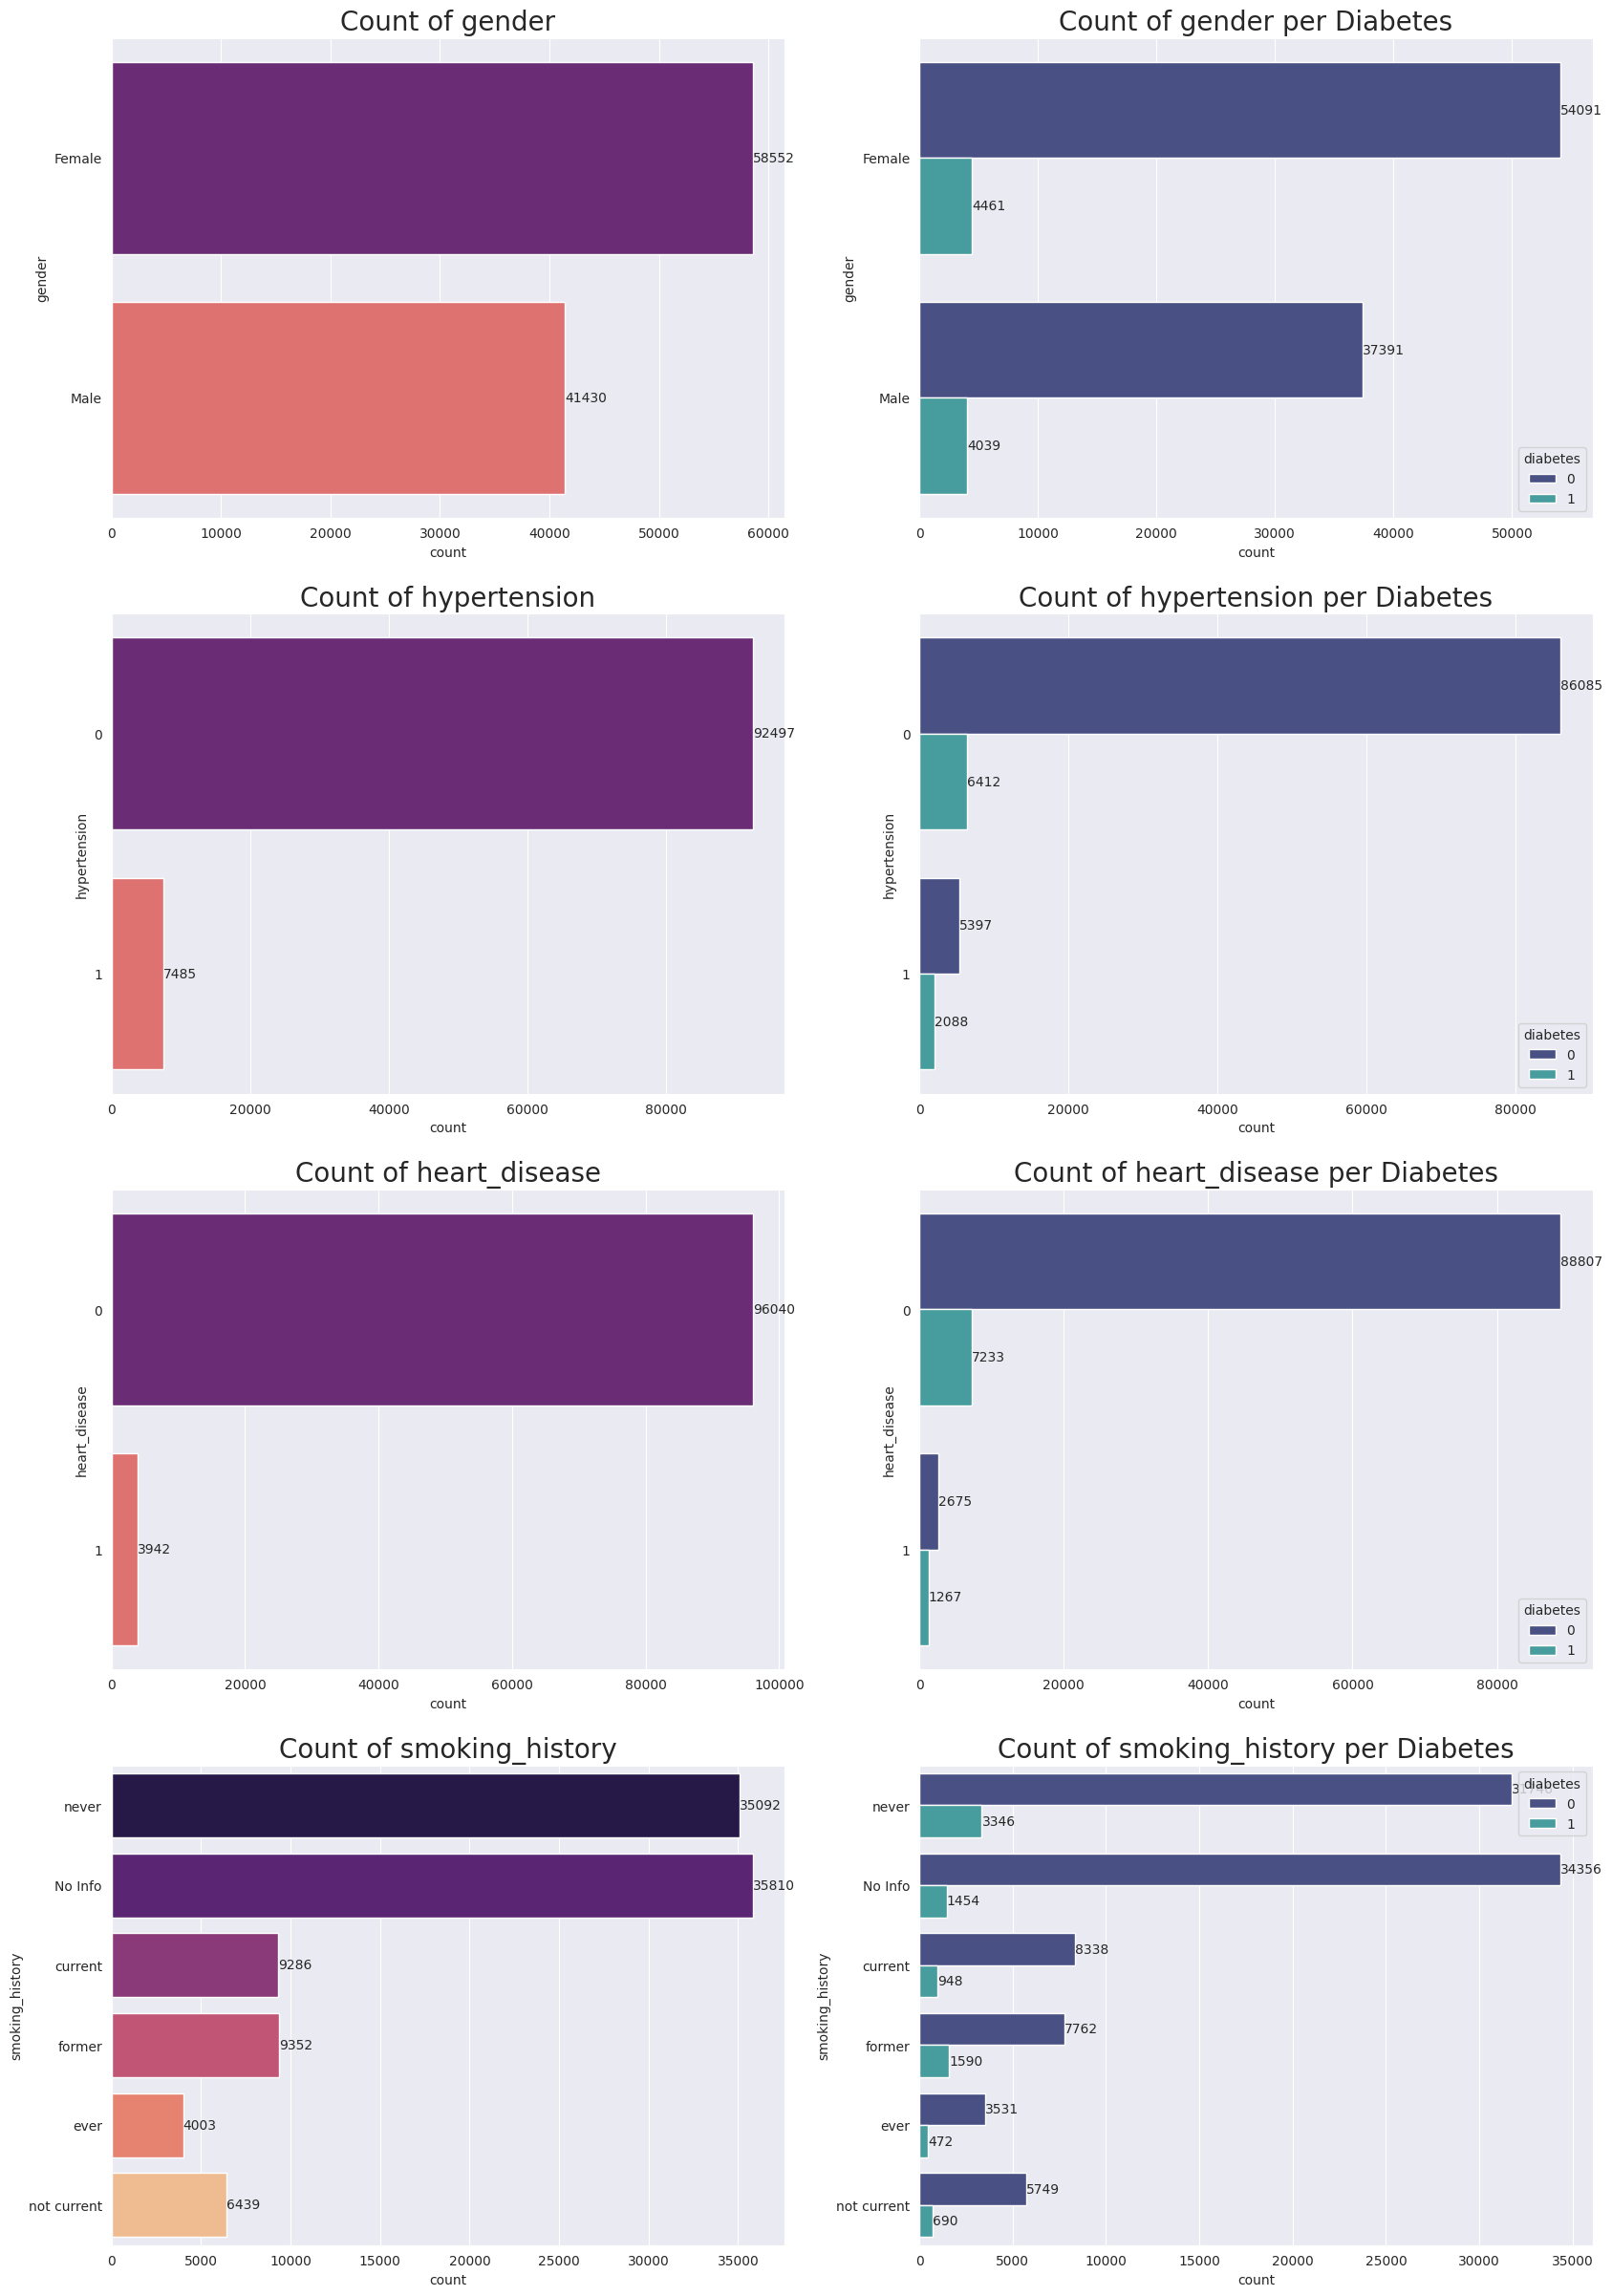

In [10]:
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
fig, axes = plt.subplots(4,2, figsize=(20,30))
sns.set_style('darkgrid')
idx = 0
for col in categorical_columns:
    sns.countplot(data=data, y=col, palette='magma', orient='h',
                  ax=axes[idx][0]).set_title(f'Count of {col}', fontsize='20')
    for container in axes[idx][0].containers:
        axes[idx][0].bar_label(container)
    sns.countplot(data=data, y=col, palette='mako', orient='h',  hue='diabetes',
                  ax=axes[idx][1]).set_title(f'Count of {col} per Diabetes', fontsize='20')
    for container in axes[idx][1].containers:
        axes[idx][1].bar_label(container)
    idx +=1
plt.show()

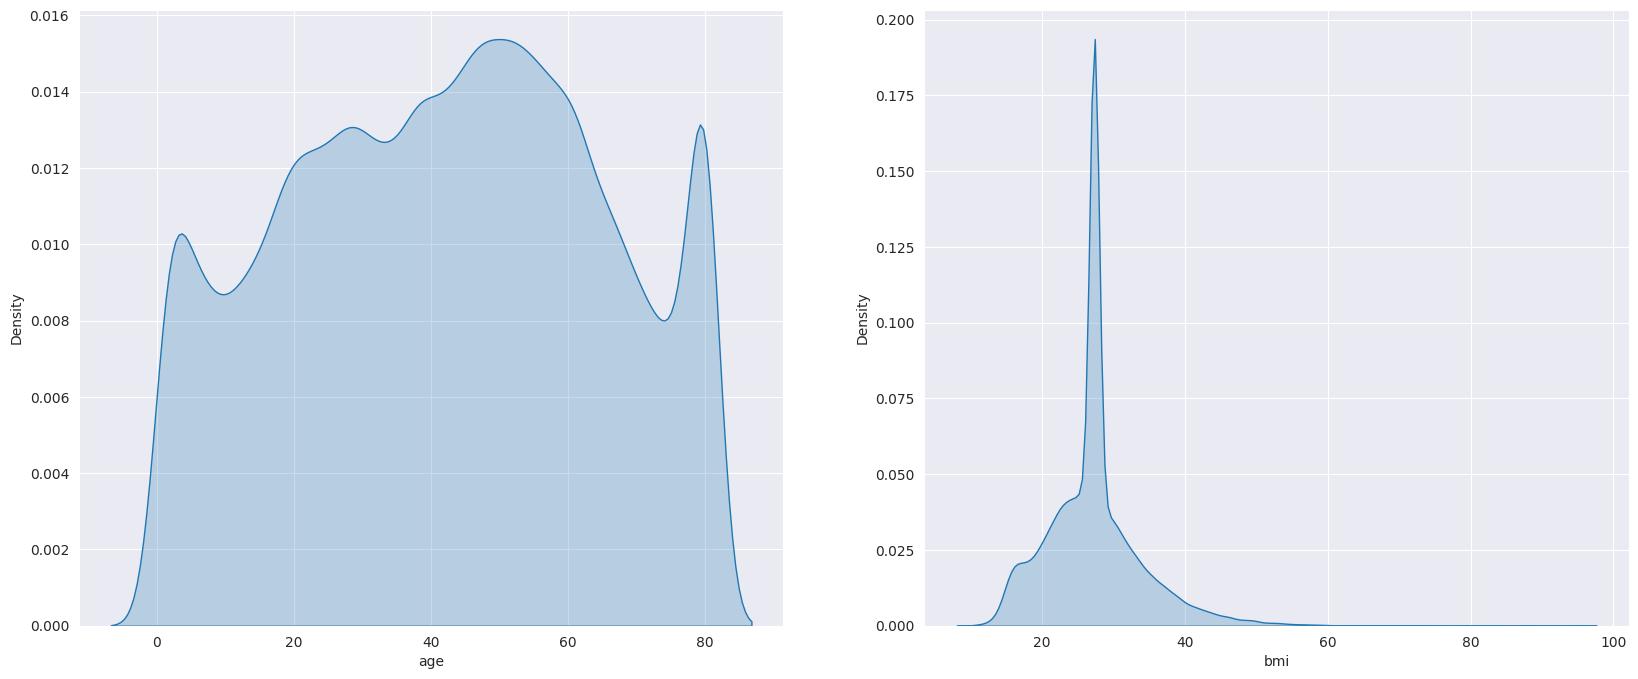

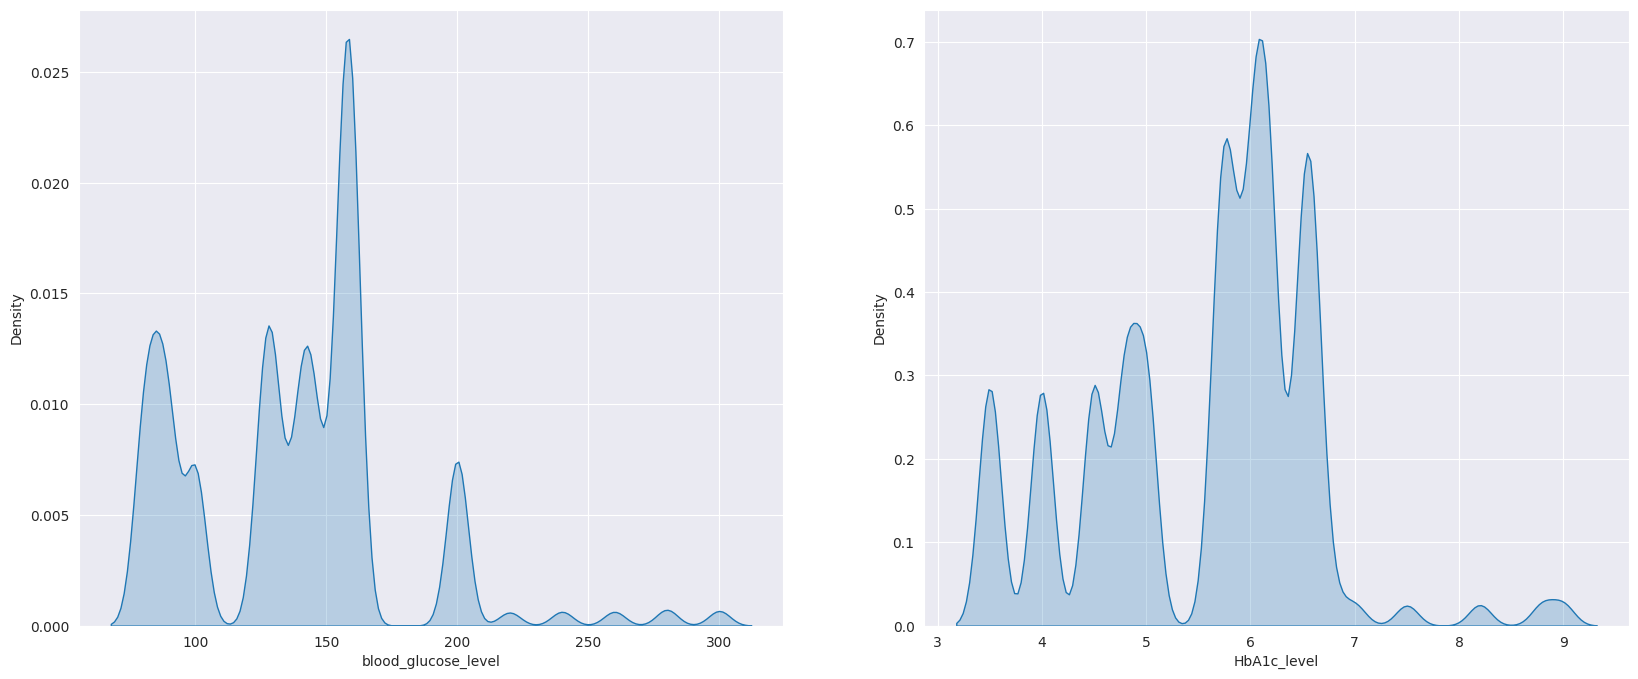

<Figure size 640x480 with 0 Axes>

In [11]:
numerical = ['age', 'bmi', 'blood_glucose_level', 'HbA1c_level']
i = 0

while i < 4:
  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  sns.kdeplot(data[numerical[i]], fill=True)
  i += 1
  if i == 4:
    break
  plt.subplot(1, 2, 2)
  sns.kdeplot(data[numerical[i]], fill=True)
  i += 1

  plt.show()

plt.savefig('2')

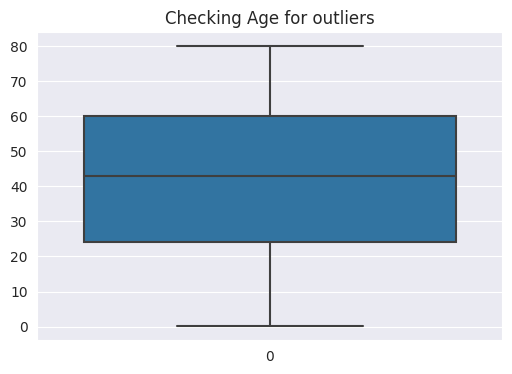

In [12]:
plt.figure(figsize=(6, 4))
plt.title('Checking Age for outliers')
sns.boxplot(data['age'])

plt.show()

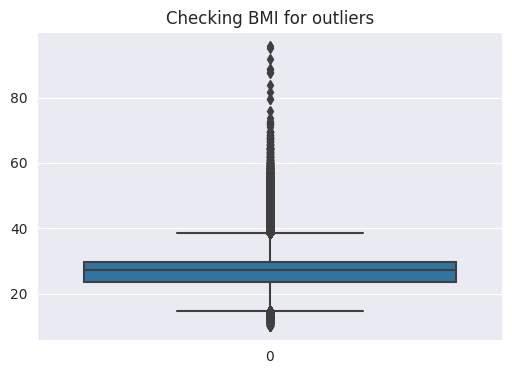

In [13]:
plt.figure(figsize=(6, 4))
plt.title('Checking BMI for outliers')
sns.boxplot(data['bmi'])

plt.show()

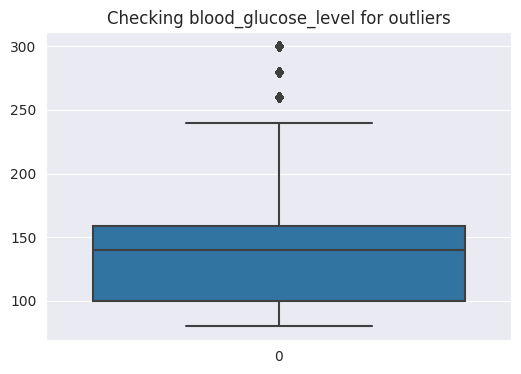

In [14]:
plt.figure(figsize=(6, 4))
plt.title('Checking blood_glucose_level for outliers')
sns.boxplot(data['blood_glucose_level'])

plt.show()

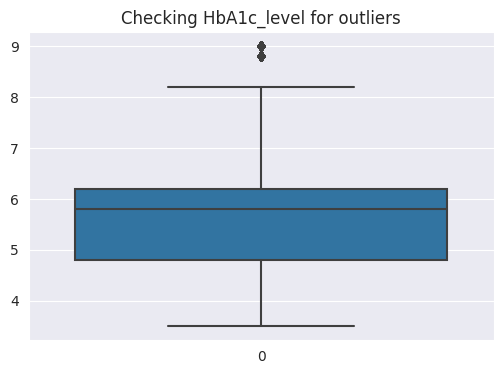

In [15]:
plt.figure(figsize=(6, 4))
plt.title('Checking HbA1c_level for outliers')
sns.boxplot(data['HbA1c_level'])

plt.show()

14.705
38.504999999999995


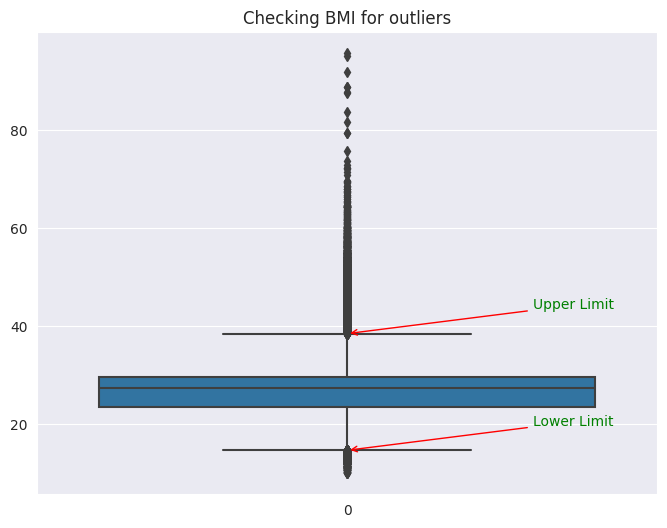

In [16]:
q1 = np.quantile(data['bmi'], 0.25)
q3 = np.quantile(data['bmi'], 0.75)
IQR = q3 - q1
lower_limit = q1 - (1.5 * IQR)
upper_limit = q3 + (1.5 * IQR)
print(lower_limit)
print(upper_limit)

plt.figure(figsize=(8, 6))
plt.title('Checking BMI for outliers')
sns.boxplot(data['bmi'])

points_to_annotate = [(lower_limit, 'Lower Limit'), (upper_limit, "Upper Limit")]

for point, label in points_to_annotate:
    plt.annotate(
        label,
        xy=(0, point),
        xytext=(0.3, point+5),
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=10, color='green'
    )

plt.show()

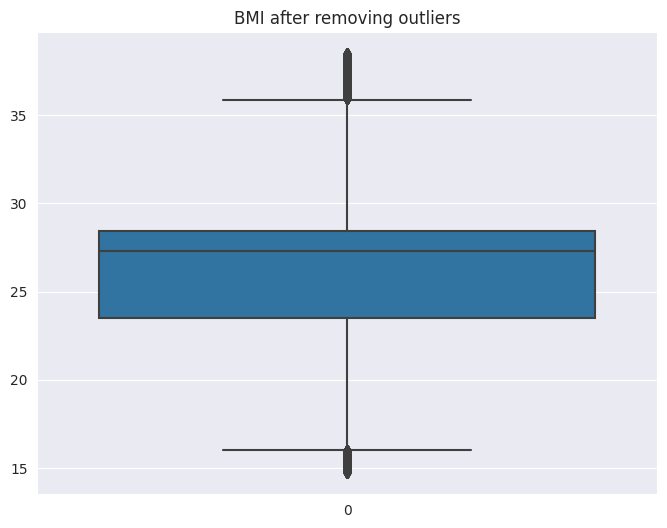

In [17]:
outliers = data[(data['bmi'] < lower_limit) | (data['bmi'] > upper_limit)]
data = data.drop(outliers.index)
plt.figure(figsize=(8, 6))
plt.title('BMI after removing outliers')
sns.boxplot(data['bmi'])
plt.show()

11.5
247.5


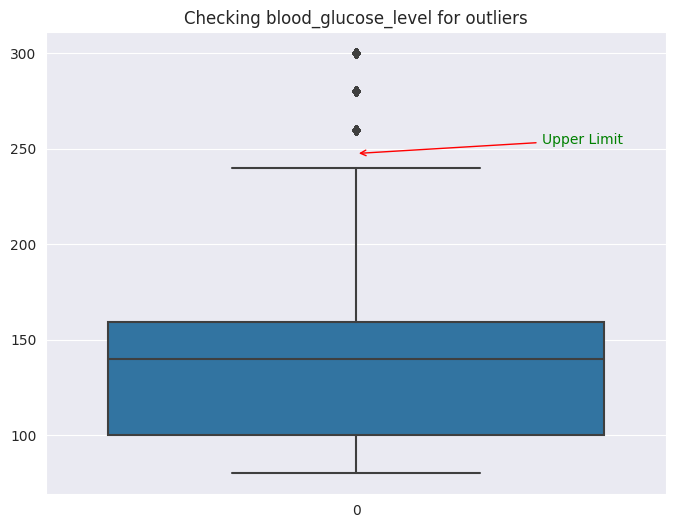

In [18]:
q1 = np.quantile(data['blood_glucose_level'], 0.25)
q3 = np.quantile(data['blood_glucose_level'], 0.75)
IQR = q3 - q1
lower_limit = q1 - (1.5 * IQR)
upper_limit = q3 + (1.5 * IQR)
print(lower_limit)
print(upper_limit)

plt.figure(figsize=(8, 6))
plt.title('Checking blood_glucose_level for outliers')
sns.boxplot(data['blood_glucose_level'])

points_to_annotate = [(lower_limit, 'Lower Limit'), (upper_limit, "Upper Limit")]

for point, label in points_to_annotate:
    plt.annotate(
        label,
        xy=(0, point),
        xytext=(0.3, point+5),
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=10, color='green'
    )

plt.show()

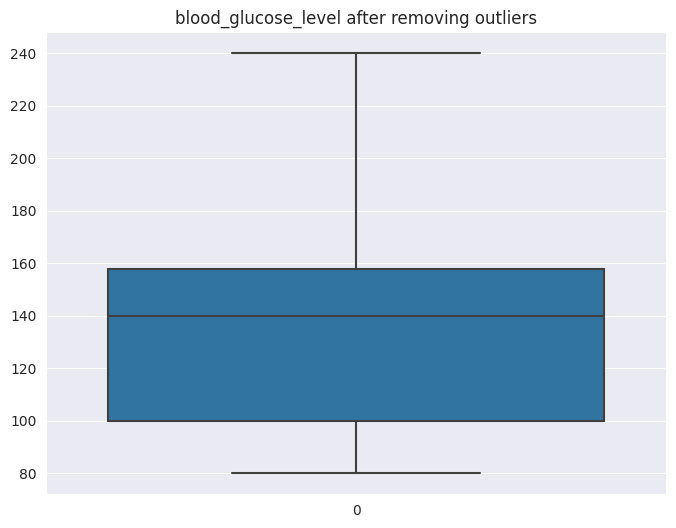

In [19]:
outliers = data[(data['blood_glucose_level'] < lower_limit) | (data['blood_glucose_level'] > upper_limit)]
data = data.drop(outliers.index)
plt.figure(figsize=(8, 6))
plt.title('blood_glucose_level after removing outliers')
sns.boxplot(data['blood_glucose_level'])
plt.show()

2.6999999999999993
8.3


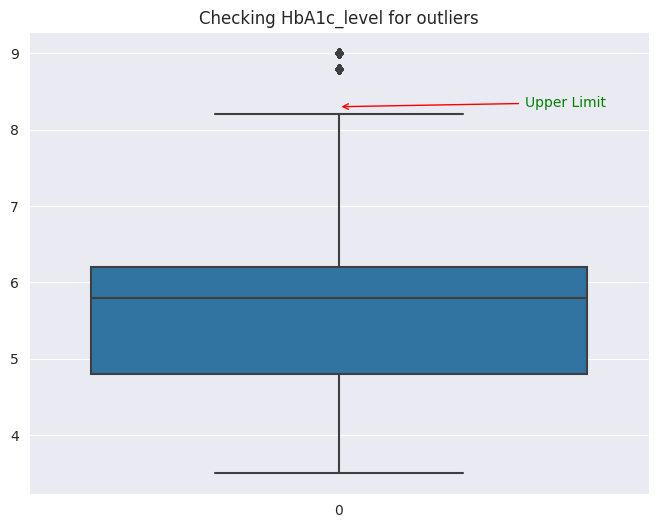

In [20]:
q1 = np.quantile(data['HbA1c_level'], 0.25)
q3 = np.quantile(data['HbA1c_level'], 0.75)
IQR = q3 - q1
lower_limit = q1 - (1.5 * IQR)
upper_limit = q3 + (1.5 * IQR)
print(lower_limit)
print(upper_limit)

plt.figure(figsize=(8, 6))
plt.title('Checking HbA1c_level for outliers')
sns.boxplot(data['HbA1c_level'])

points_to_annotate = [(lower_limit, 'Lower Limit'), (upper_limit, "Upper Limit")]

for point, label in points_to_annotate:
    plt.annotate(
        label,
        xy=(0, point),
        xytext=(0.3, point),
        arrowprops=dict(arrowstyle='->', color='red'),
        fontsize=10, color='green'
    )

plt.show()

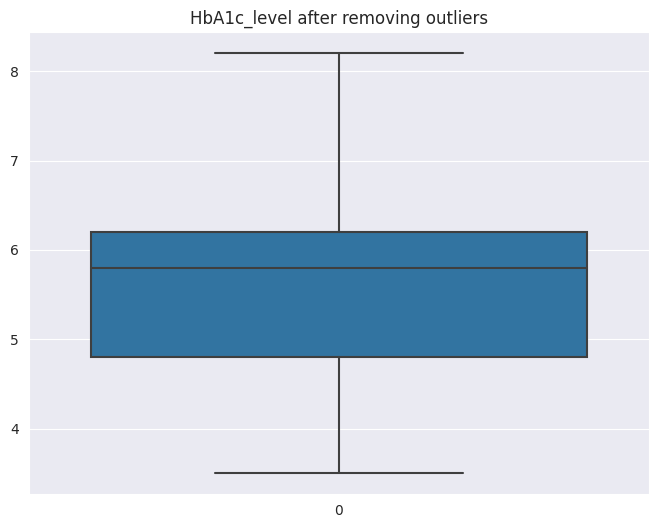

In [21]:
outliers = data[(data['HbA1c_level'] < lower_limit) | (data['HbA1c_level'] > upper_limit)]
data = data.drop(outliers.index)
plt.figure(figsize=(8, 6))
plt.title('HbA1c_level after removing outliers')
sns.boxplot(data['HbA1c_level'])
plt.show()

In [22]:
data.shape

(90370, 9)

In [23]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [24]:
data.duplicated().sum()

3844

In [25]:
data.drop_duplicates(inplace=True)

In [26]:
data.duplicated().sum()

0

In [27]:
bins = [0, 20, 40, 60, np.inf]
labels = ['0-20', '21-40', '41-60', 'upper_61']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

           Total  Diabetes  Diabetes (%)
age_group                               
0-20       17698        63      0.355972
21-40      22762       299      1.313593
41-60      25048      1382      5.517407
upper_61   21018      2743     13.050718


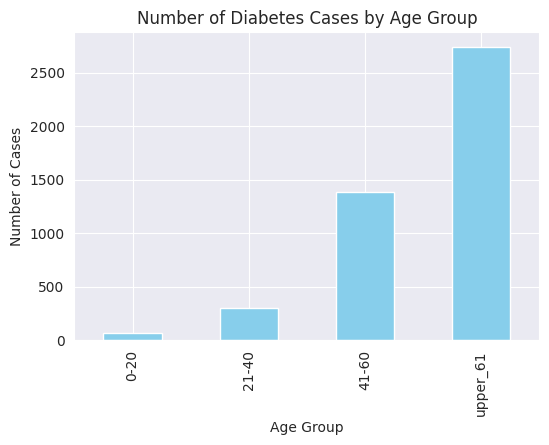

In [28]:
diabetes_by_age_group = data[data['diabetes'] == 1].groupby('age_group').size()

total_by_age_group = data.groupby('age_group').size()

result = pd.DataFrame({
    'Total': total_by_age_group,
    'Diabetes': diabetes_by_age_group
}).fillna(0)

result['Diabetes (%)'] = (result['Diabetes'] / result['Total']) * 100

print(result)

result['Diabetes'].plot(kind='bar', color='skyblue', figsize=(6, 4))
plt.title('Number of Diabetes Cases by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Cases')
plt.show()

In [29]:
data.drop(columns=['age'], axis=1, inplace=True)

In [30]:
data

,gender,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group
0,Female,0,1,never,25.19,6.6,140,0,upper_61
1,Female,0,0,No Info,27.32,6.6,80,0,41-60
2,Male,0,0,never,27.32,5.7,158,0,21-40
3,Female,0,0,current,23.45,5.0,155,0,21-40
4,Male,1,1,current,20.14,4.8,155,0,upper_61
...,...,...,...,...,...,...,...,...,...
99994,Female,0,0,No Info,24.60,4.8,145,0,21-40
99996,Female,0,0,No Info,17.37,6.5,100,0,0-20
99997,Male,0,0,former,27.83,5.7,155,0,upper_61
99998,Female,0,0,never,35.42,4.0,100,0,21-40


In [31]:
categorical = data[['gender', 'smoking_history', 'age_group']]
data.drop(columns=['gender', 'smoking_history', 'age_group'], axis=1, inplace=True)

In [32]:
categorical

,gender,smoking_history,age_group
0,Female,never,upper_61
1,Female,No Info,41-60
2,Male,never,21-40
3,Female,current,21-40
4,Male,current,upper_61
...,...,...,...
99994,Female,No Info,21-40
99996,Female,No Info,0-20
99997,Male,former,upper_61
99998,Female,never,21-40


In [33]:
categorical = categorical.apply(LabelEncoder().fit_transform)

In [34]:
categorical

,gender,smoking_history,age_group
0,0,4,3
1,0,0,2
2,1,4,1
3,0,1,1
4,1,1,3
...,...,...,...
99994,0,0,1
99996,0,0,0
99997,1,3,3
99998,0,4,1


In [35]:
newData = pd.concat([data, categorical], axis=1)
newData

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender,smoking_history,age_group
0,0,1,25.19,6.6,140,0,0,4,3
1,0,0,27.32,6.6,80,0,0,0,2
2,0,0,27.32,5.7,158,0,1,4,1
3,0,0,23.45,5.0,155,0,0,1,1
4,1,1,20.14,4.8,155,0,1,1,3
...,...,...,...,...,...,...,...,...,...
99994,0,0,24.60,4.8,145,0,0,0,1
99996,0,0,17.37,6.5,100,0,0,0,0
99997,0,0,27.83,5.7,155,0,1,3,3
99998,0,0,35.42,4.0,100,0,0,4,1


In [36]:
corr = newData.corr()
corr['diabetes'].sort_values(ascending=False)

diabetes               1.000000
HbA1c_level            0.263330
blood_glucose_level    0.216539
age_group              0.207183
hypertension           0.159406
heart_disease          0.144974
bmi                    0.142616
smoking_history        0.066817
gender                 0.036201
Name: diabetes, dtype: float64

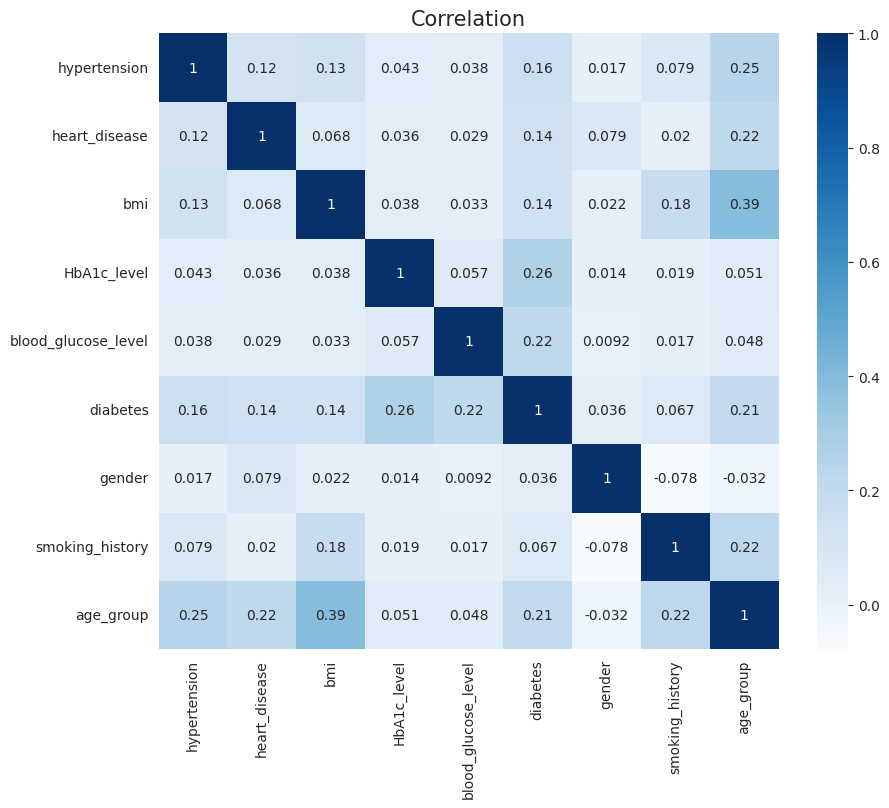

In [37]:
plt.figure(figsize=(10, 8))
plt.title('Correlation', fontsize=15)
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()

In [38]:
target = newData['diabetes']
data = newData.drop(columns=['diabetes'], axis=1)

In [39]:
X = np.array(data)
y = np.array(target)

def fisher_score_manual(X, y, feature_names):
    scores = []
    n_classes = np.unique(y)

    for i in range(X.shape[1]):
        numerator = 0
        denominator = 0
        overall_mean = np.mean(X[:, i])

        for c in n_classes:
            class_samples = X[y == c, i]
            class_mean = np.mean(class_samples)
            class_variance = np.var(class_samples)
            class_count = len(class_samples)

            numerator += class_count * (class_mean - overall_mean) ** 2
            denominator += class_count * class_variance

        score = numerator / (denominator + 1e-10)
        scores.append(score)


    feature_scores = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)

    for name, score in zip(feature_names, scores):
        print(f"Feature: {name}, Fisher Score: {score:.4f}")

    return np.array(scores)


feature_names = data.columns
fisher_scores = fisher_score_manual(X, y, feature_names)

Feature: hypertension, Fisher Score: 0.0261
Feature: heart_disease, Fisher Score: 0.0215
Feature: bmi, Fisher Score: 0.0208
Feature: HbA1c_level, Fisher Score: 0.0745
Feature: blood_glucose_level, Fisher Score: 0.0492
Feature: gender, Fisher Score: 0.0013
Feature: smoking_history, Fisher Score: 0.0045
Feature: age_group, Fisher Score: 0.0448


In [40]:
data.drop(columns=['gender', 'smoking_history'], axis=1, inplace=True)

In [41]:
print(data.shape)
print(target.shape)

(86526, 6)
(86526,)


In [42]:
target.value_counts()

diabetes
0    82039
1     4487
Name: count, dtype: int64

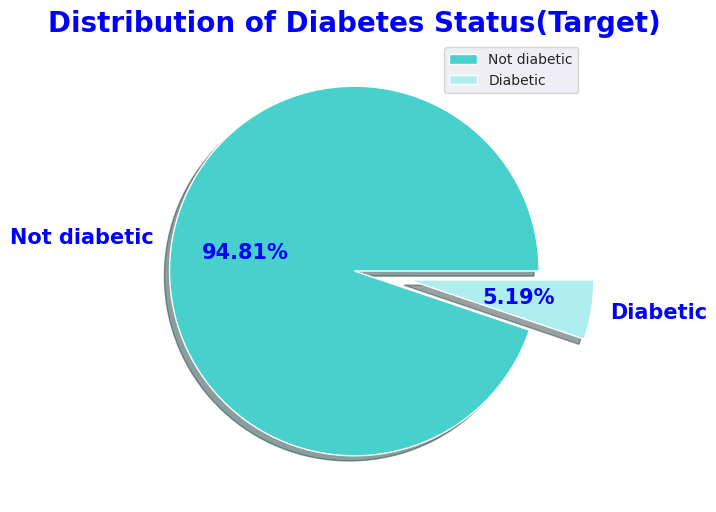

In [43]:
x = target.value_counts()

sns.set_style('darkgrid')
explode = [0, 0.3]
labels = ['Not diabetic', 'Diabetic']
colors = ['mediumturquoise', 'paleturquoise']
fig, ax = plt.subplots(figsize=(8, 6))

plt.title('Distribution of Diabetes Status(Target)', fontsize=20, fontweight='bold', color='blue')
plt.pie(x, explode=explode, shadow=True, colors=colors, autopct='%.2f%%', labels=labels, textprops=dict(color="Blue", weight='bold', size=15))
plt.legend()
plt.show()

In [44]:
def Smote(data, target):
    counter = Counter(target)
    print('before Oversampling: ', counter)
    smote = SMOTE()
    data, target = smote.fit_resample(data, target)
    counter = Counter(target)
    print('after Oversampling: ', counter)
    return data, target

data, target = Smote(data, target)

before Oversampling:  Counter({0: 82039, 1: 4487})
after Oversampling:  Counter({0: 82039, 1: 82039})


In [45]:
data['age_group'].value_counts()

age_group
3    66948
2    50049
1    28240
0    18841
Name: count, dtype: int64

In [46]:
xtrain, xtest, ytrain, ytest = train_test_split(data, target, test_size=0.3, stratify=target)

In [47]:
print(xtrain.shape)
print(ytrain.shape)
print()
print(xtest.shape)
print(ytest.shape)

(114854, 6)
(114854,)

(49224, 6)
(49224,)


In [48]:
scaler = MinMaxScaler()
xtrain = pd.DataFrame(scaler.fit_transform(xtrain), columns=xtrain.columns)
xtest = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns)

In [49]:
def metrics_calculator(y_test, y_pred, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result



def plot_result(y_pred, model_name) :
    '''
    1) plot Confusion Matrix
    2) plot Classification Report
    '''

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    # plt.title(model_name)
    fig.tight_layout()
    #AX left - Confusion Matrix
    cm =confusion_matrix(ytest, y_pred)
    ax[0]=sns.heatmap(cm, cmap='Blues', annot=True, fmt='', linewidths=0.5, ax=ax[0])
    ax[0].set_xlabel('Prediced labels', fontsize=18)
    ax[0].set_ylabel('True labels', fontsize=18)
    ax[0].set_title(f'Confusion Matrix for {model_name} model', fontsize=18)
    # ax[0].xaxis.set_ticklabels(['GAD Positive', 'GAD Negative'])
    # ax[0].yaxis.set_ticklabels(['GAD Positive', 'GAD Negative'])
    #
    # AX Right - Classification Report
    cr = pd.DataFrame(classification_report(ytest, y_pred,output_dict=True)).T
    cr.drop(columns='support', inplace=True)
    ax[1] = sns.heatmap(cr, cmap='Blues', annot=True, fmt='0.3f', linewidths=0.5, ax=ax[1])
    ax[1].xaxis.tick_top()
    ax[1].set_title(f'Classification Report for {model_name} model', fontsize=18)
    plt.show()

In [50]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': ['balanced']}

gridSearch = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, cv=5, scoring='accuracy')
gridSearch.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [51]:
Logistic = gridSearch.best_estimator_
Logistic.fit(xtrain, ytrain)

LogisticRegression(C=0.01, class_weight='balanced')

In [52]:
kf1 = KFold(n_splits=5)
cv_scores1 = cross_val_score(Logistic, xtrain, ytrain, cv=kf1, scoring='accuracy')

In [53]:
print('Cv Scores')
print(cv_scores1)
print('Cv Scores Accuracy Mean: ', cv_scores1.mean())

Cv Scores
[0.85560054 0.85372861 0.85320622 0.85433808 0.85433174]
Cv Scores Accuracy Mean:  0.8542410372359674


In [54]:
prediction_on_training_data_logistic = Logistic.predict(xtrain)
metrics_calculator(ytrain, prediction_on_training_data_logistic, 'LogisticRegression_OnTraining')

,LogisticRegression_OnTraining
Accuracy,0.854241
Precision,0.855077
Recall,0.854241
F1-score,0.854155


In [55]:
logistic_prediction = Logistic.predict(xtest)
metrics_calculator(ytest, logistic_prediction, 'LogisticRegression_OnTesting')

,LogisticRegression_OnTesting
Accuracy,0.851820
Precision,0.852780
Recall,0.851820
F1-score,0.851719


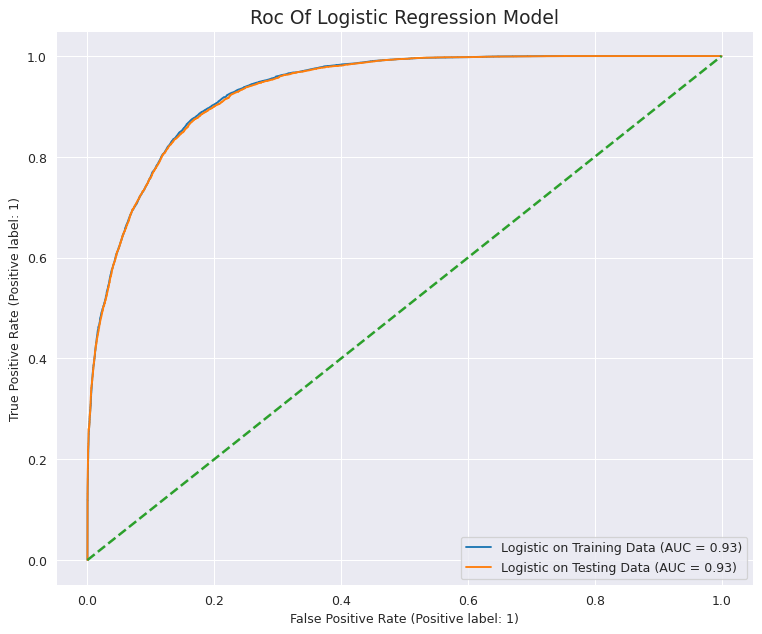

In [56]:
def roc_curve(Model):
    fig, ax = plt.subplots(figsize=(10, 8), dpi=90)
    plt.title('Roc Of Logistic Regression Model', fontsize=15)
    RocCurveDisplay.from_estimator(Logistic, xtrain, ytrain, ax=ax, name='Logistic on Training Data')
    RocCurveDisplay.from_estimator(Logistic, xtest, ytest, ax=ax, name='Logistic on Testing Data')

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
    plt.show()


roc_curve(Logistic)

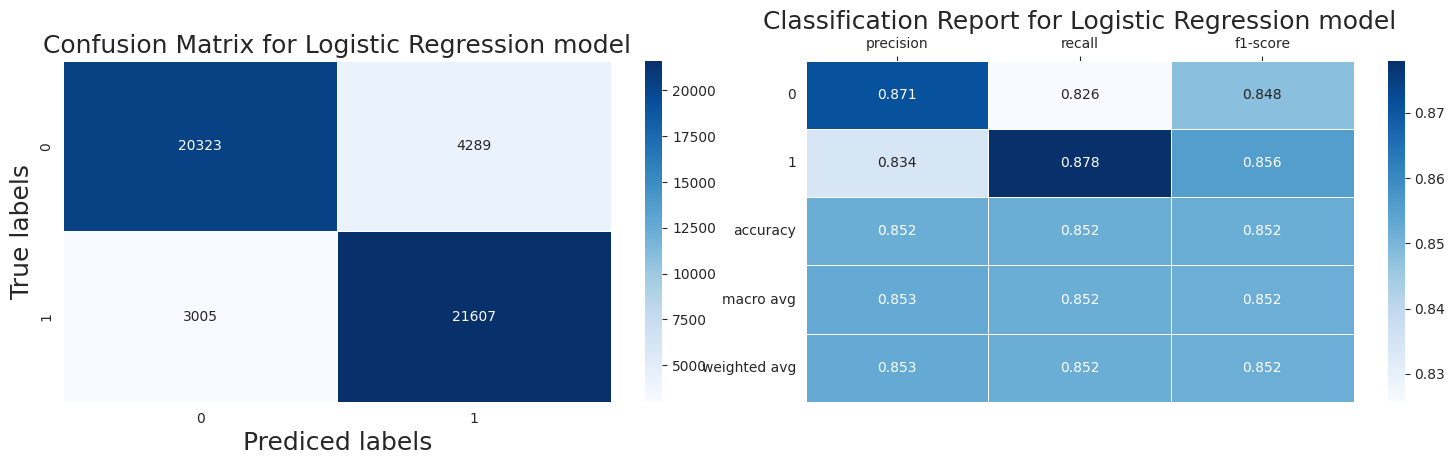

In [57]:
plot_result(logistic_prediction, 'Logistic Regression')

In [107]:
from sklearn.svm import SVC


svc = SVC(C=3, class_weight='balanced')
svc.fit(xtrain, ytrain)

SVC(C=3, class_weight='balanced')

In [59]:
kf2 = KFold(n_splits=5)
cv_scores2 = cross_val_score(svc, xtrain, ytrain, cv=kf2, scoring='accuracy')

In [60]:
print('Cv Scores')
print(cv_scores2)
print('Cv Scores Accuracy Mean: ', cv_scores2.mean())

Cv Scores
[0.87688825 0.87606112 0.87371033 0.8736668  0.87331302]
Cv Scores Accuracy Mean:  0.8747279031214747


In [61]:
prediction_on_training_data_svc = svc.predict(xtrain)
metrics_calculator_svc_train = metrics_calculator(ytrain, prediction_on_training_data_svc, 'SVC_OnTraining')
metrics_calculator_svc_train

,SVC_OnTraining
Accuracy,0.875155
Precision,0.879934
Recall,0.875155
F1-score,0.874761


In [62]:
svc_prediction = svc.predict(xtest)
metrics_calculator_svc_test = metrics_calculator(ytest, svc_prediction, 'SVC_OnTesting')
metrics_calculator_svc_test

,SVC_OnTesting
Accuracy,0.875427
Precision,0.880573
Recall,0.875427
F1-score,0.875004


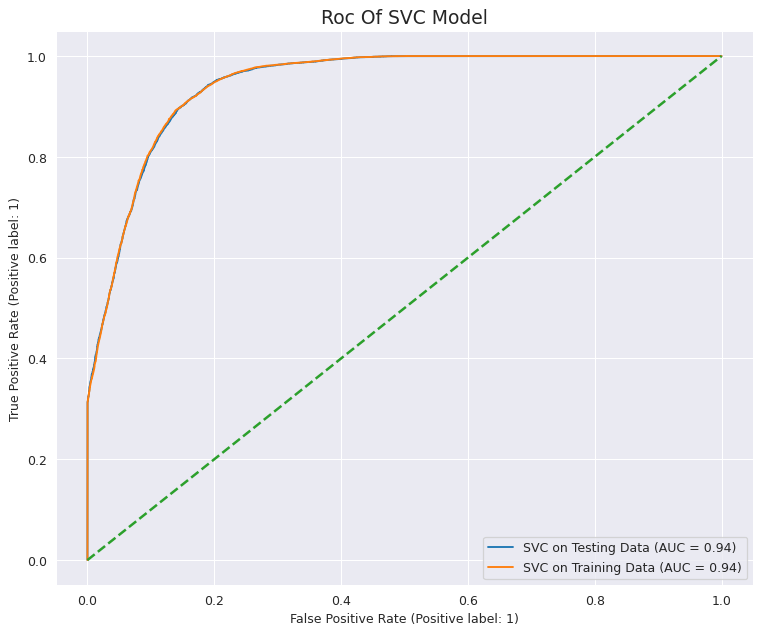

In [63]:
def roc_curve(Model):
    fig, ax = plt.subplots(figsize=(10, 8), dpi=90)
    plt.title('Roc Of SVC Model', fontsize=15)
    RocCurveDisplay.from_estimator(svc, xtest, ytest, ax=ax, name='SVC on Testing Data')   # test data
    RocCurveDisplay.from_estimator(svc, xtrain, ytrain, ax=ax, name='SVC on Training Data')   # train data

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
    plt.show()


roc_curve(svc)

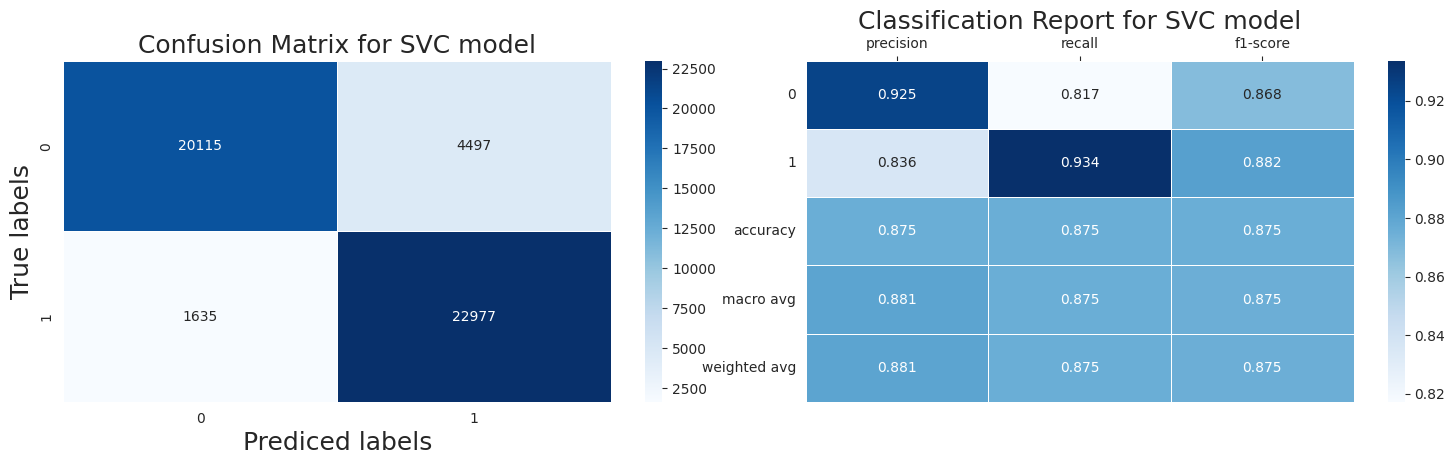

In [64]:
plot_result(svc_prediction, 'SVC')

In [65]:
def grid_search_tree():
    tree = DecisionTreeClassifier()

    param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16],
                'min_samples_leaf': [2, 3, 8,10, 15, 20, 50]}

    gridSearch = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
    gridSearch.fit(xtrain, ytrain)

    Tree = gridSearch.best_estimator_
    Tree.fit(xtrain, ytrain)

    return Tree


Tree = grid_search_tree()
Tree

DecisionTreeClassifier(max_depth=16, max_features='sqrt', min_samples_leaf=2)

In [66]:
kf3 = KFold(n_splits=5)
cv_scores3 = cross_val_score(Tree, xtrain, ytrain, cv=kf3, scoring='accuracy')

In [67]:
print('Cv Scores')
print(cv_scores3)
print('Cv Scores Accuracy Mean: ', cv_scores3.mean())

Cv Scores
[0.9213356  0.90988638 0.91380436 0.90879805 0.91562908]
Cv Scores Accuracy Mean:  0.9138906937362885


In [68]:
prediction_on_training_data_tree = Tree.predict(xtrain)
metrics_calculator_tree_train = metrics_calculator(ytrain, prediction_on_training_data_tree, 'Tree_OnTraining')
metrics_calculator_tree_train

,Tree_OnTraining
Accuracy,0.920656
Precision,0.920885
Recall,0.920656
F1-score,0.920645


In [69]:
tree_prediction = Tree.predict(xtest)
metrics_calculator_tree_test = metrics_calculator(ytest, tree_prediction, 'Tree_OnTesting')
metrics_calculator_tree_test

,Tree_OnTesting
Accuracy,0.911913
Precision,0.912143
Recall,0.911913
F1-score,0.911901


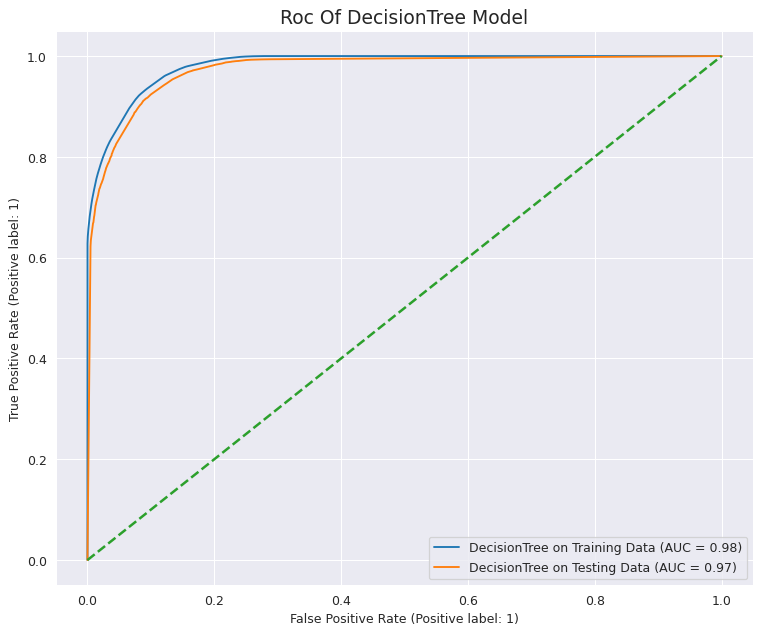

In [70]:
def roc_curve(Model):
    fig, ax = plt.subplots(figsize=(10, 8), dpi=90)
    plt.title('Roc Of DecisionTree Model', fontsize=15)
    RocCurveDisplay.from_estimator(Tree, xtrain, ytrain, ax=ax, name='DecisionTree on Training Data')
    RocCurveDisplay.from_estimator(Tree, xtest, ytest, ax=ax, name='DecisionTree on Testing Data')

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
    plt.show()


roc_curve(Tree)

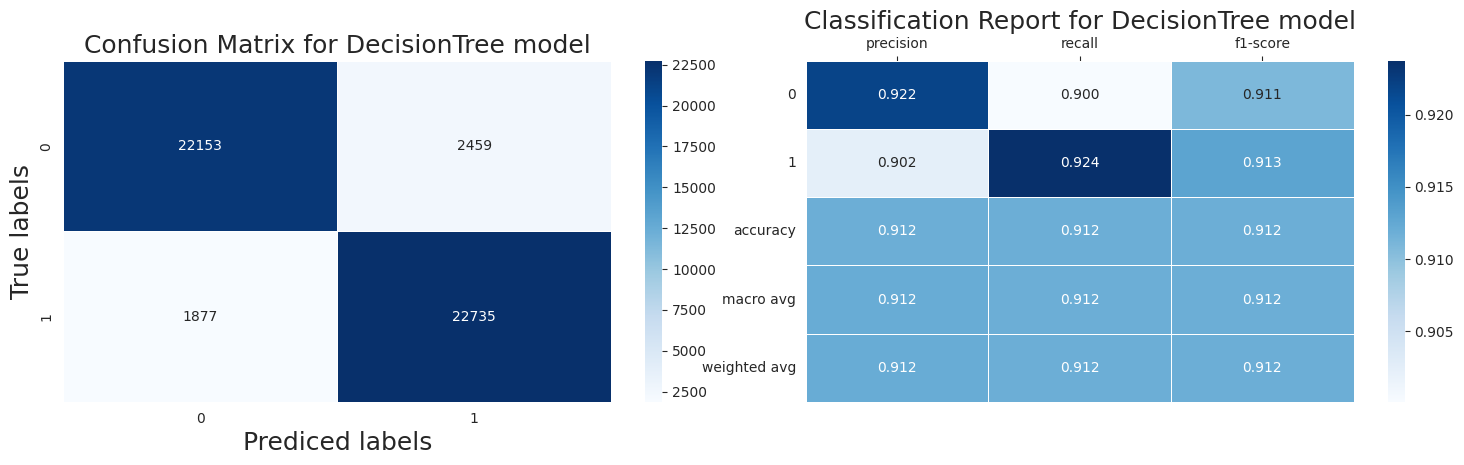

In [71]:
plot_result(tree_prediction, 'DecisionTree')

In [72]:
knn = KNeighborsClassifier()
parameters = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

gridSearch = GridSearchCV(estimator=knn, param_grid=parameters, cv=5, scoring='accuracy')
gridSearch.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [73]:
KnnModel = gridSearch.best_estimator_
KnnModel.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [74]:
kf4 = KFold(n_splits=5)
score4 = cross_val_score(KnnModel, xtrain, ytrain, cv=kf4, scoring='accuracy')
print(score4)
print(score4.mean())

[0.93078229 0.93052109 0.9296069  0.92721257 0.92982151]
0.9295888713726551


In [75]:
prediction_on_training_data_knn = KnnModel.predict(xtrain)
metrics_calculator_knn_train = metrics_calculator(ytrain, prediction_on_training_data_knn, 'KNN_OnTraining')
metrics_calculator_knn_train

,KNN_OnTraining
Accuracy,0.983631
Precision,0.983639
Recall,0.983631
F1-score,0.983631


In [76]:
knn_prediction = KnnModel.predict(xtest)
metrics_calculator_knn_test = metrics_calculator(ytest, knn_prediction, 'KNN_OnTesting')
metrics_calculator_knn_test

,KNN_OnTesting
Accuracy,0.933853
Precision,0.933960
Recall,0.933853
F1-score,0.933849


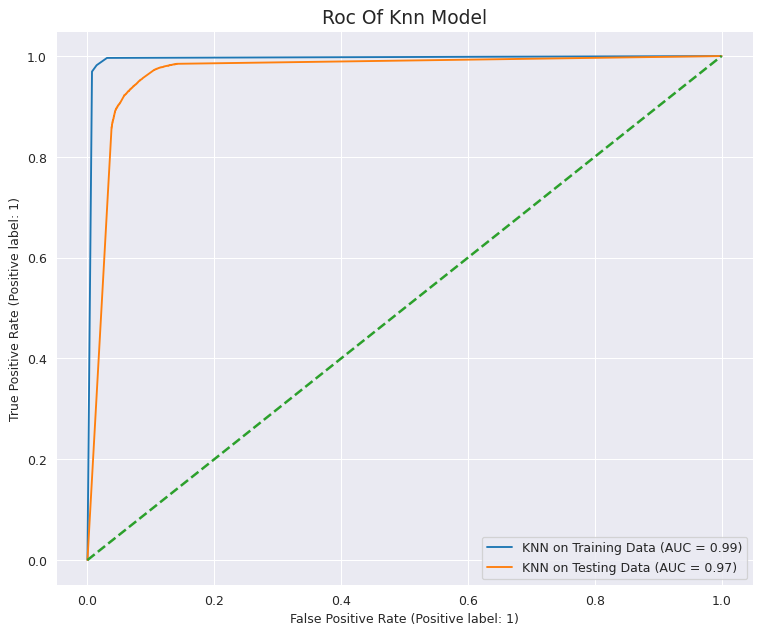

In [77]:
def roc_curve(Model):
    fig, ax = plt.subplots(figsize=(10, 8), dpi=90)
    plt.title('Roc Of Knn Model', fontsize=15)
    RocCurveDisplay.from_estimator(KnnModel, xtrain, ytrain, ax=ax, name='KNN on Training Data')
    RocCurveDisplay.from_estimator(KnnModel, xtest, ytest, ax=ax, name='KNN on Testing Data')

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
    plt.show()


roc_curve(KnnModel)

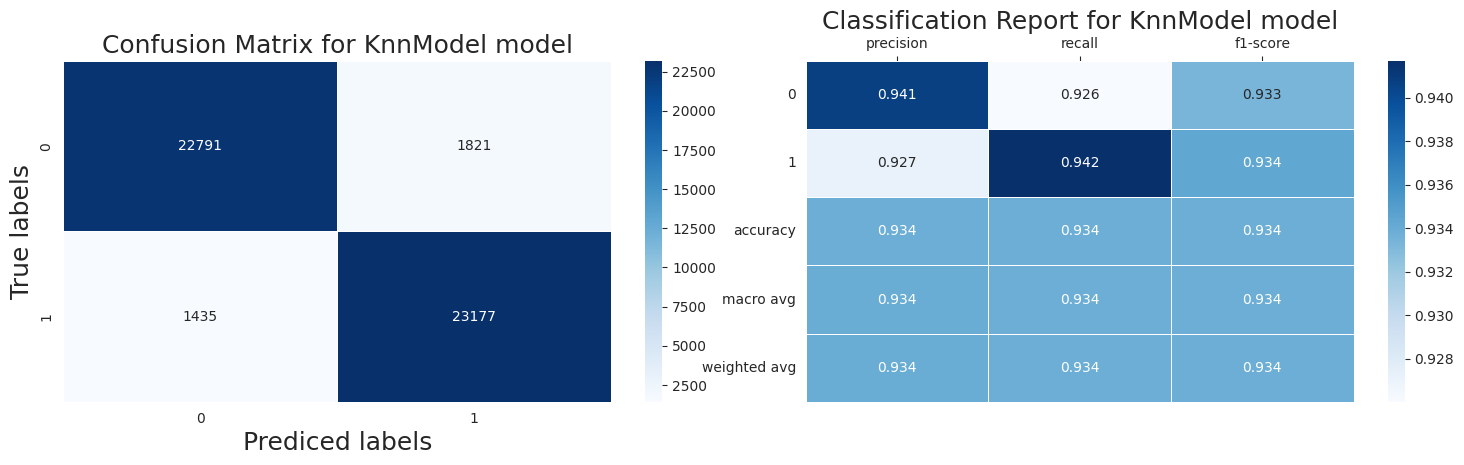

In [78]:
plot_result(knn_prediction, 'KnnModel')

In [79]:
RandomForest = RandomForestClassifier()
RandomForest.fit(xtrain, ytrain)

RandomForestClassifier()

In [80]:
kf5 = KFold(n_splits=5)
cv_scores5 = cross_val_score(RandomForest, xtrain, ytrain, cv=kf5, scoring='accuracy')

In [81]:
print('Cv Scores')
print(cv_scores5)
print('Cv Scores Accuracy Mean: ', cv_scores5.mean())

Cv Scores
[0.95820818 0.95690218 0.95907884 0.95590092 0.9569003 ]
Cv Scores Accuracy Mean:  0.9573980836733685


In [82]:
prediction_on_training_data_rf = RandomForest.predict(xtrain)
metrics_calculator_rf_train = metrics_calculator(ytrain, prediction_on_training_data_rf, 'RandomForest_OnTraining')
metrics_calculator_rf_train

,RandomForest_OnTraining
Accuracy,0.986174
Precision,0.986179
Recall,0.986174
F1-score,0.986174


In [83]:
rf_prediction = RandomForest.predict(xtest)
metrics_calculator_rf_test = metrics_calculator(ytest, rf_prediction, 'RandomForest_OnTesting')
metrics_calculator_rf_test

,RandomForest_OnTesting
Accuracy,0.959349
Precision,0.959371
Recall,0.959349
F1-score,0.959349


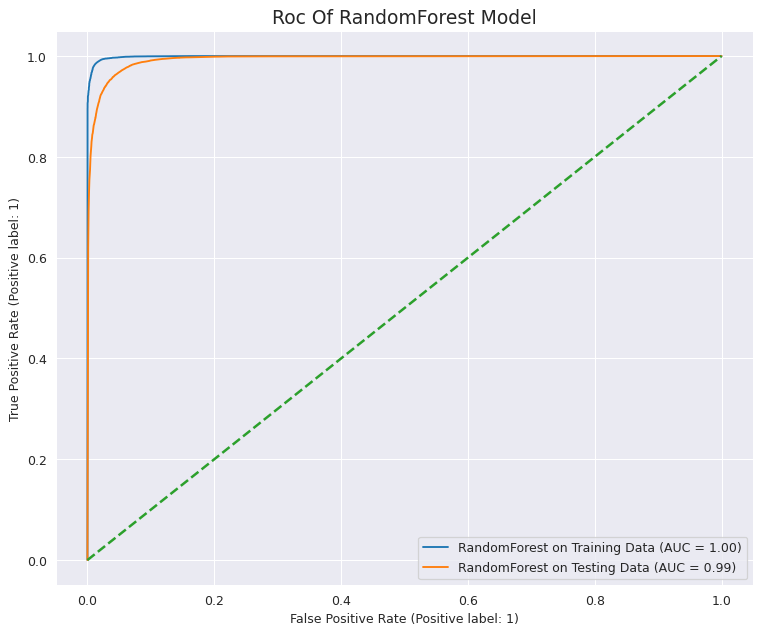

In [84]:
def roc_curve(Model):
    fig, ax = plt.subplots(figsize=(10, 8), dpi=90)
    plt.title('Roc Of RandomForest Model', fontsize=15)
    RocCurveDisplay.from_estimator(RandomForest, xtrain, ytrain, ax=ax, name='RandomForest on Training Data')   # train data
    RocCurveDisplay.from_estimator(RandomForest, xtest, ytest, ax=ax, name='RandomForest on Testing Data')   # test data

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
    plt.show()


roc_curve(RandomForest)

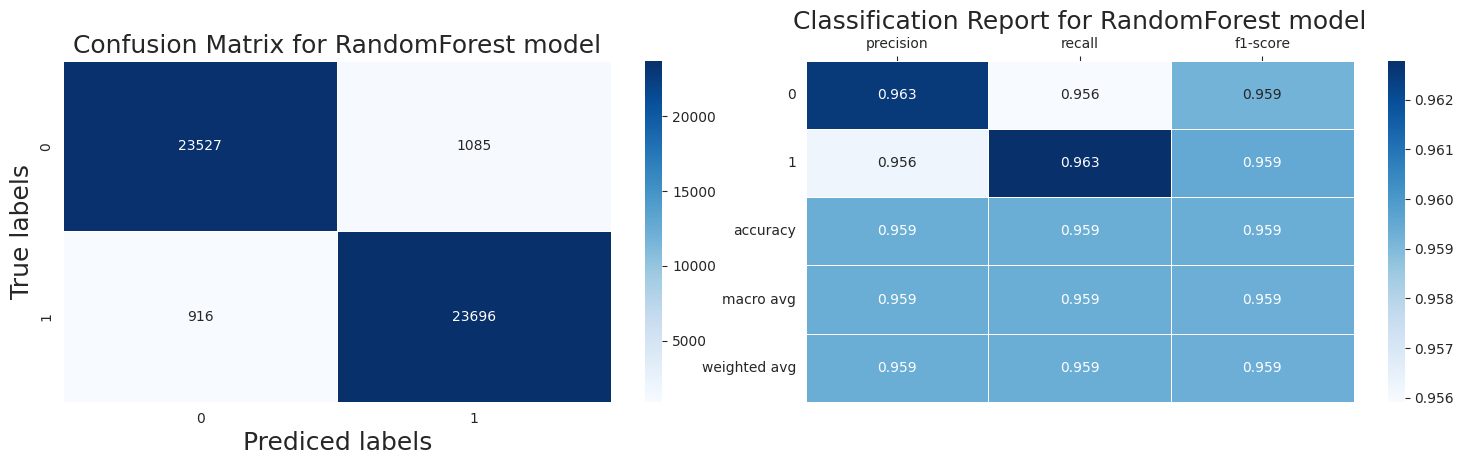

In [85]:
plot_result(rf_prediction, 'RandomForest')

In [86]:
from sklearn.naive_bayes import GaussianNB
Naive = GaussianNB()
Naive.fit(xtrain, ytrain)

GaussianNB()

In [87]:
kf6 = KFold(n_splits=5)
cv_scores6 = cross_val_score(Naive, xtrain, ytrain, cv=kf6, scoring='accuracy')

In [88]:
print('Cv Scores')
print(cv_scores6)
print('Cv Scores Accuracy Mean: ', cv_scores6.mean())

Cv Scores
[0.8170737  0.81555004 0.81750903 0.81450525 0.81754462]
Cv Scores Accuracy Mean:  0.8164365290550993


In [89]:
prediction_on_training_data_naive = Naive.predict(xtrain)
metrics_calculator_naive_train = metrics_calculator(ytrain, prediction_on_training_data_naive, 'NaiveBayes_OnTraining')
metrics_calculator_naive_train

,NaiveBayes_OnTraining
Accuracy,0.816437
Precision,0.817474
Recall,0.816437
F1-score,0.816286


In [90]:
naive_prediction = Naive.predict(xtest)
metrics_calculator_naive_test = metrics_calculator(ytest, naive_prediction, 'NaiveBayes_OnTesting')
metrics_calculator_naive_test

,NaiveBayes_OnTesting
Accuracy,0.816512
Precision,0.817581
Recall,0.816512
F1-score,0.816358


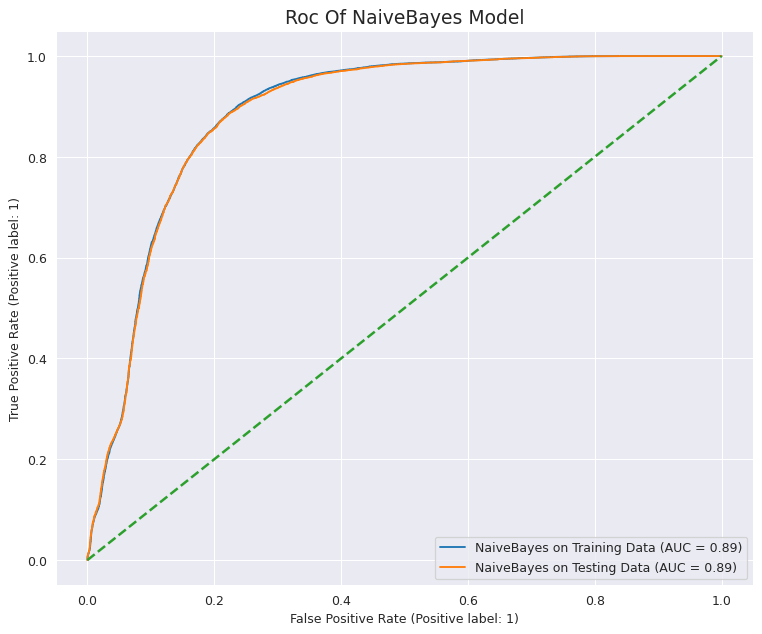

In [91]:
def roc_curve(Model):
    fig, ax = plt.subplots(figsize=(10, 8), dpi=90)
    plt.title('Roc Of NaiveBayes Model', fontsize=15)
    RocCurveDisplay.from_estimator(Naive, xtrain, ytrain, ax=ax, name='NaiveBayes on Training Data')   # train data
    RocCurveDisplay.from_estimator(Naive, xtest, ytest, ax=ax, name='NaiveBayes on Testing Data')   # test data

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
    plt.show()


roc_curve(Naive)

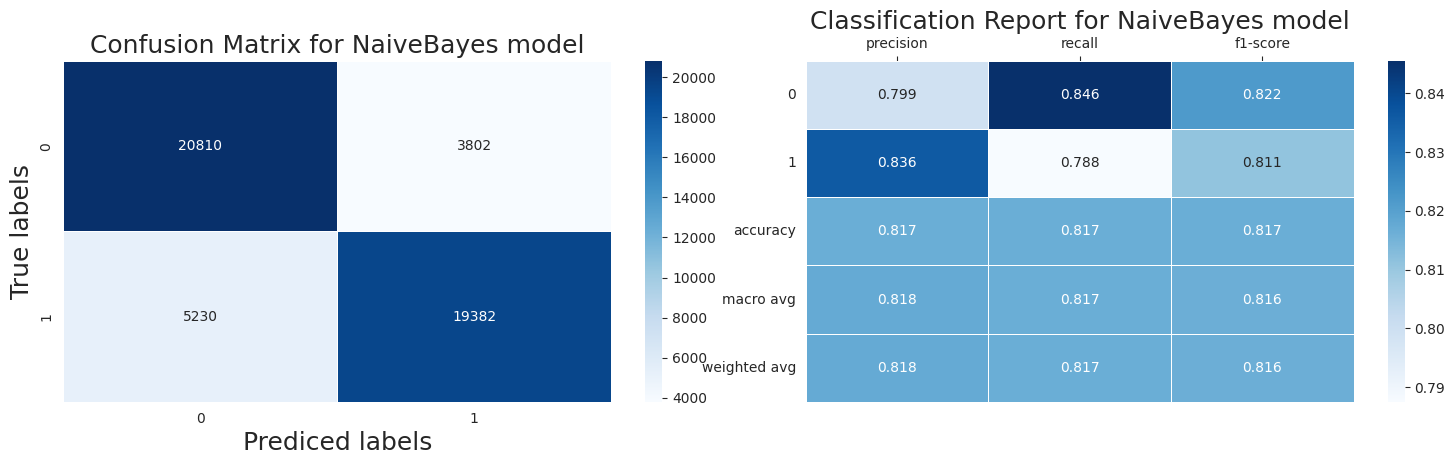

In [92]:
plot_result(naive_prediction, 'NaiveBayes')

In [93]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, input_dim=6, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.2))


model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,713 (1.17 MB)

 Trainable params: 307,713 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

In [95]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [96]:
hist = model.fit(xtrain, ytrain, epochs=50, validation_split=0.15, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6529 - auc: 0.7492 - loss: 0.5946 - precision: 0.6185 - recall: 0.8209 - val_accuracy: 0.8546 - val_auc: 0.9335 - val_loss: 0.3320 - val_precision: 0.8407 - val_recall: 0.8701 - learning_rate: 0.0010
Epoch 2/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8470 - auc: 0.9225 - loss: 0.3486 - precision: 0.8245 - recall: 0.8848 - val_accuracy: 0.8633 - val_auc: 0.9385 - val_loss: 0.3139 - val_precision: 0.8408 - val_recall: 0.8917 - learning_rate: 0.0010
Epoch 3/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8583 - auc: 0.9321 - loss: 0.3205 - precision: 0.8256 - recall: 0.9088 - val_accuracy: 0.8693 - val_auc: 0.9420 - val_loss: 0.2944 - val_precision: 0.8282 - val_recall: 0.9273 - learning_rate: 0.0010
Epoch 4/50
3051/3051 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8638 - auc: 0.9368 - loss: 0.3051 - precision: 0.8258 - recall: 0.9215 - val_accuracy: 0.8700 - val_auc: 0.9445 - val_loss: 0.2

In [97]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    precision = hist.history['precision']
    val_pre = hist.history['val_precision']
    recall = hist.history['recall']
    val_rec = hist.history['val_recall']
    auc = hist.history['auc']
    val_auc = hist.history['val_auc']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 15))
    sns.set_style('darkgrid')

    plt.subplot(3, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(Epochs, precision, 'r', label= 'Training Precision')
    plt.plot(Epochs, val_pre, 'g', label= 'Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(Epochs, recall, 'r', label= 'Training Recall')
    plt.plot(Epochs, val_rec, 'g', label= 'Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()


    plt.subplot(3, 2, 5)
    plt.plot(Epochs, auc, 'r', label= 'Training AUC')
    plt.plot(Epochs, val_auc, 'g', label= 'Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

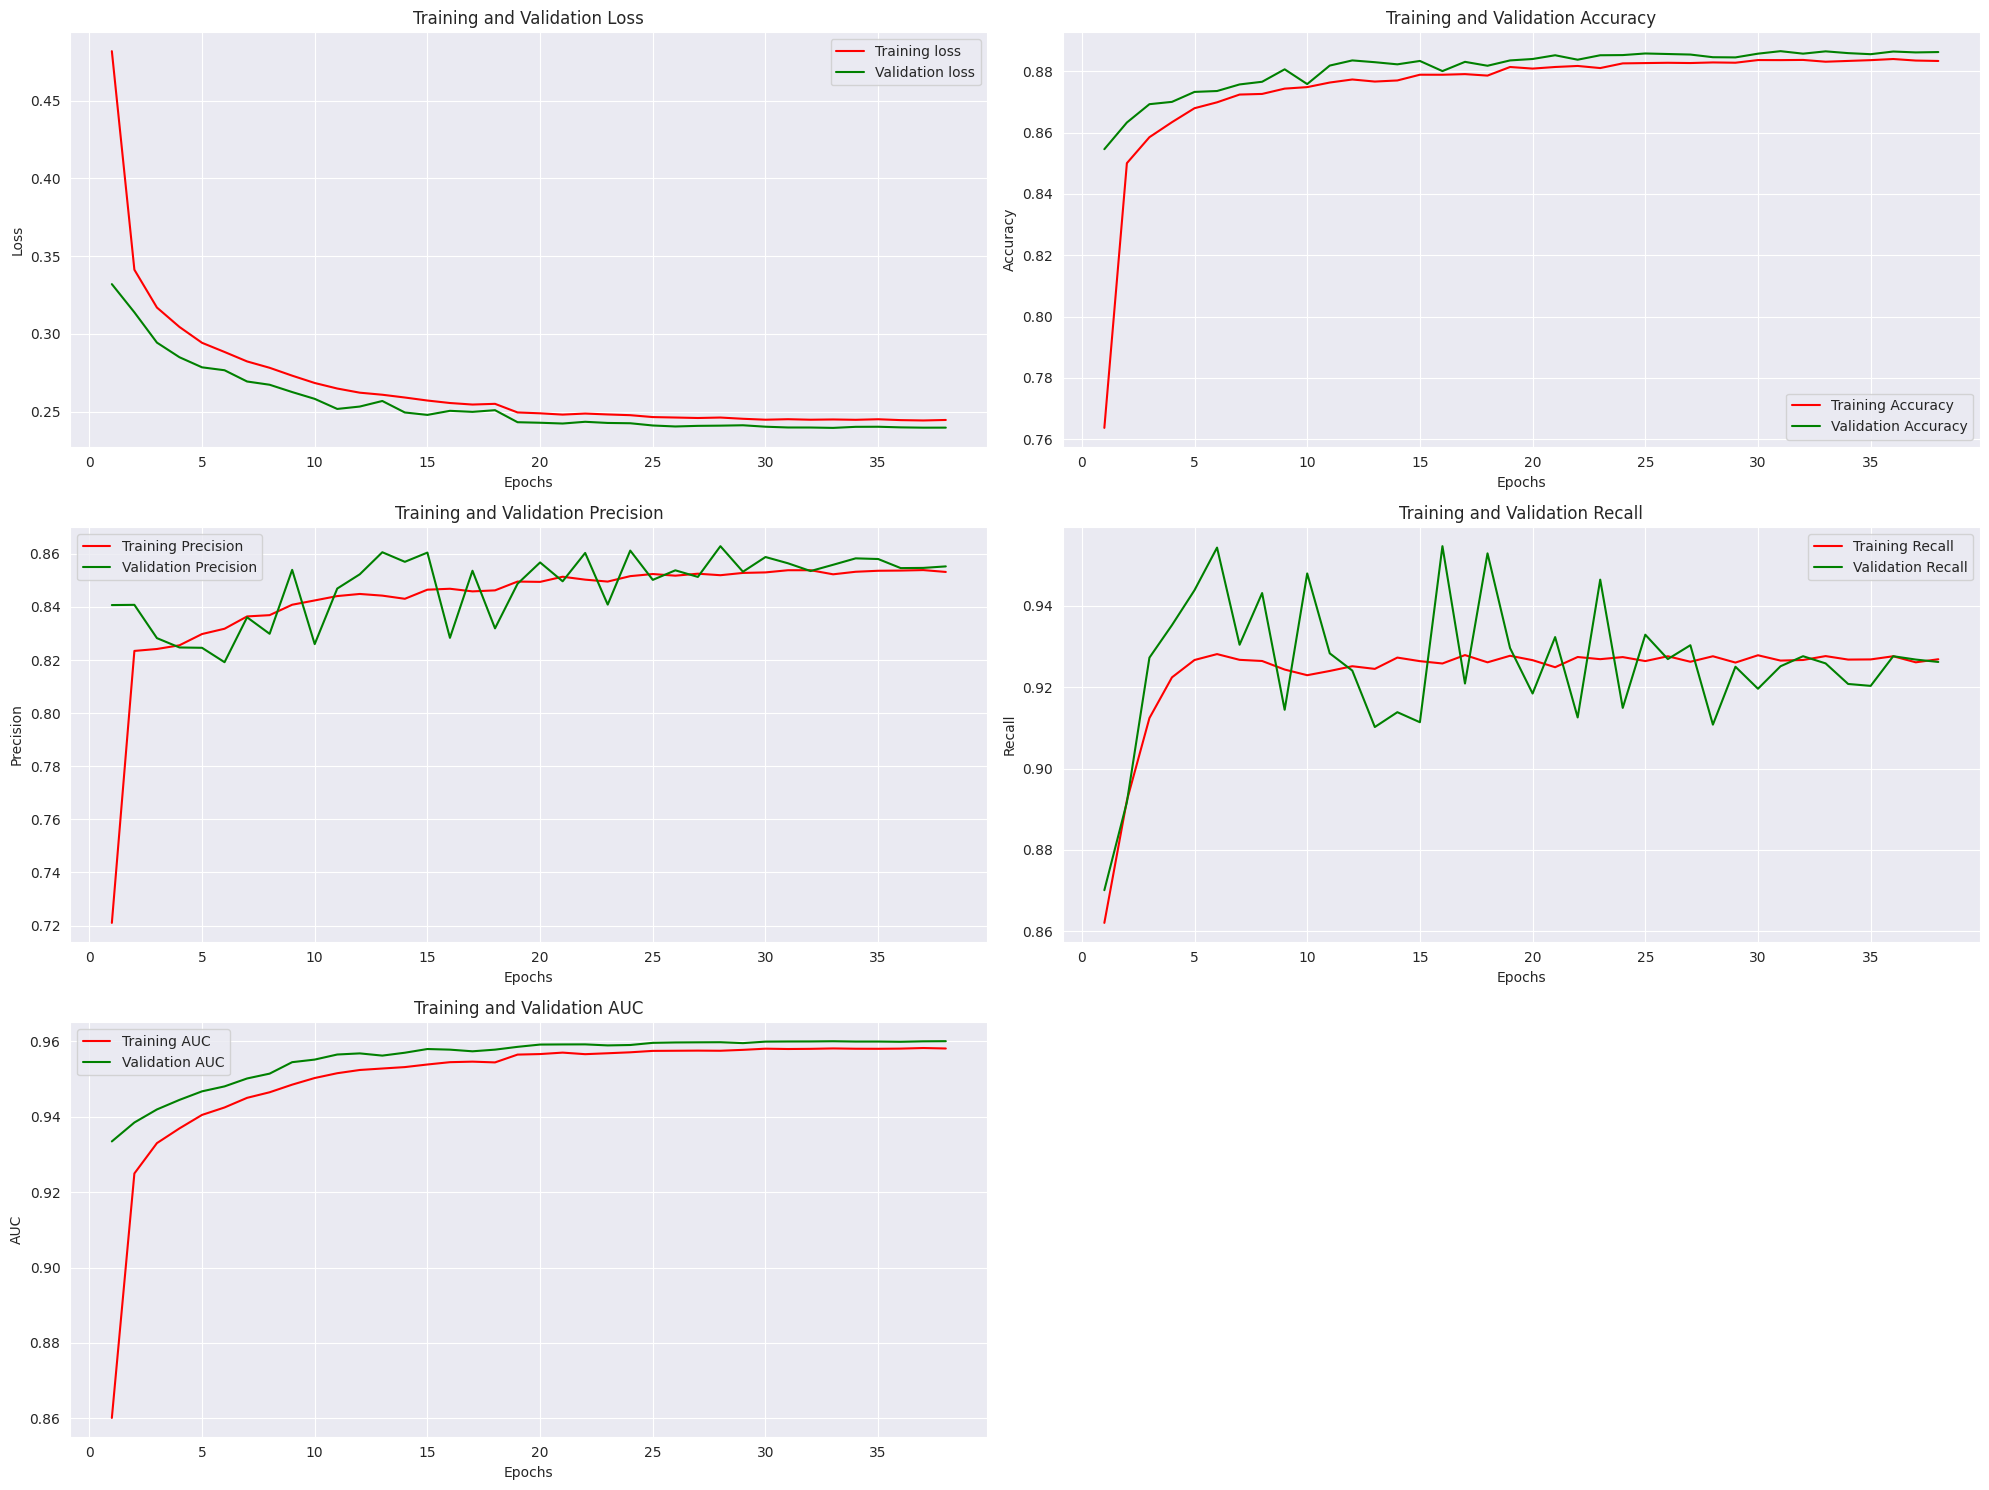

In [98]:
model_performance(hist, 50)

In [99]:
train_loss, train_accuracy, train_precision, train_recall, train_auc = model.evaluate(xtrain, ytrain, verbose=0)
print('Training Loss: ', train_loss)
print('Training Accuracy: ', train_accuracy)
print('Training Precision: ', train_precision)
print('Training Recall: ', train_recall)
print('Training AUC: ', train_auc)

Training Loss:  0.24009279906749725
Training Accuracy:  0.8850540518760681
Training Precision:  0.857154369354248
Training Recall:  0.9241123795509338
Training AUC:  0.960039496421814


In [100]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(xtest, ytest, verbose=0)
print('Testing Loss: ', test_loss)
print('Testing Accuracy: ', test_accuracy)
print('Testing Precision: ', test_precision)
print('Testing Recall: ', test_recall)
print('Testing AUC: ', test_auc)

Testing Loss:  0.2410615086555481
Testing Accuracy:  0.8849138617515564
Testing Precision:  0.8566427230834961
Testing Recall:  0.9245489835739136
Testing AUC:  0.9596973657608032


In [101]:
prediction = model.predict(xtest)
prediction

1539/1539 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


array([[8.9933515e-01],
       [7.9284757e-01],
       [1.8554497e-01],
       ...,
       [9.9232882e-01],
       [6.6876829e-01],
       [1.3594520e-06]], dtype=float32)

In [102]:
print('Number of predictions greater than 0.5:', np.sum(prediction > 0.5))
print('Number of predictions less than 0.5:', np.sum(prediction < 0.5))

Number of predictions greater than 0.5: 26563
Number of predictions less than 0.5: 22661


In [103]:
threshold = 0.5
y_pred = (prediction > threshold).astype(int)

print("Unique predicted classes:", np.unique(y_pred))

Unique predicted classes: [0 1]


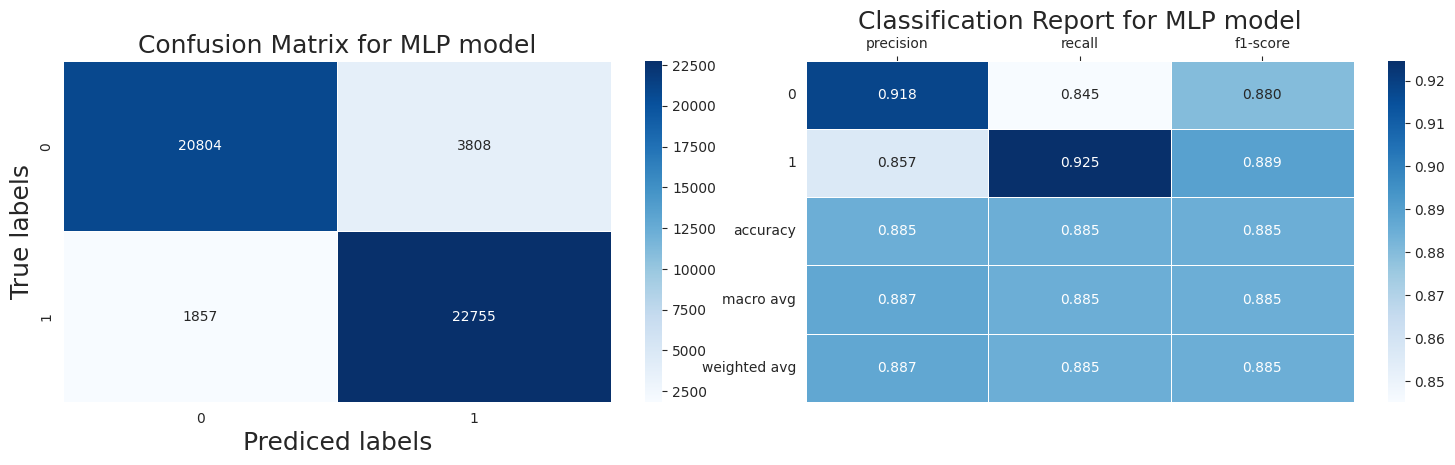

In [104]:
plot_result(y_pred, 'MLP')